<a href="https://colab.research.google.com/github/synchronizeteam/channa_classification/blob/model_aldy/Channa_resnet_crossvalidationV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import io
import gdown

from sklearn.model_selection import KFold
from google.colab import drive
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from google.colab import files
from PIL import Image
import os

%matplotlib inline

torch.manual_seed(128)

In [3]:
#Pastiin pake GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Definisi Kelas
class_names = ['andrao', 'asiatica', 'auranti', 'barca', 'maru', 'stewartii']

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Set input and output directories
# input_dir = '/content/drive/MyDrive/datasheet'
# output_dir = '/content/drive/MyDrive/datasheet_jpg'

In [ ]:
# # Loop through all image files in the input directory
# for filename in os.listdir(input_dir):
#     if filename.endswith('.png') or filename.endswith('.jpg'):
#         # Open the image file
#         img_path = os.path.join(input_dir, filename)
#         img = Image.open(img_path)

#         # Create output filename by replacing extension with .jpg
#         output_filename = os.path.splitext(filename)[0] + '.jpg'
#         output_path = os.path.join(output_dir, output_filename)

#         # Convert the image to JPEG format and save to output file
#         img.save(output_path, 'JPEG')

In [6]:
# Download Datasheet
url = "https://drive.google.com/uc?id=1P1LRTg_UZi8Ns56F8pkB8B0hAEiIwYK6"
output = "datasheet.zip"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1P1LRTg_UZi8Ns56F8pkB8B0hAEiIwYK6
To: /content/datasheet.zip
100%|██████████| 969M/969M [00:07<00:00, 129MB/s] 


'datasheet.zip'

In [7]:
#ekstrak file
!unzip "/content/datasheet.zip" -d "/content/"

Archive:  /content/datasheet.zip
  inflating: /content/datasheet/barca/barca_75.png  
  inflating: /content/datasheet/barca/barca_82.png  
  inflating: /content/datasheet/barca/barca_85.png  
  inflating: /content/datasheet/barca/barca_97.png  
  inflating: /content/datasheet/barca/barca_31.png  
  inflating: /content/datasheet/barca/barca_81.png  
  inflating: /content/datasheet/barca/barca_96.png  
  inflating: /content/datasheet/barca/barca_80.png  
  inflating: /content/datasheet/barca/barca_77.png  
  inflating: /content/datasheet/barca/barca_87.png  
  inflating: /content/datasheet/barca/barca_89.png  
  inflating: /content/datasheet/barca/barca_11.png  
  inflating: /content/datasheet/barca/barca_79.png  
  inflating: /content/datasheet/barca/barca_95.png  
  inflating: /content/datasheet/barca/barca_93.png  
  inflating: /content/datasheet/barca/barca_36.png  
  inflating: /content/datasheet/barca/barca_72.png  
  inflating: /content/datasheet/barca/barca_73.png  
  inflating: 

In [8]:
#apply pada dataset yg dipakai
dataset = torchvision.datasets.ImageFolder('/content/datasheet', transform=transform)

In [9]:
#split data train dan val, buat loader
class_indices = {}
for i, (image, label) in enumerate(dataset):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

train_indices = []
val_indices = []

for label in class_indices.keys():
    indices = class_indices[label]
    num_samples = len(indices)
    split = int(0.70 * num_samples)  #80:20 setiap kelas
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)

batch_size = 52
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

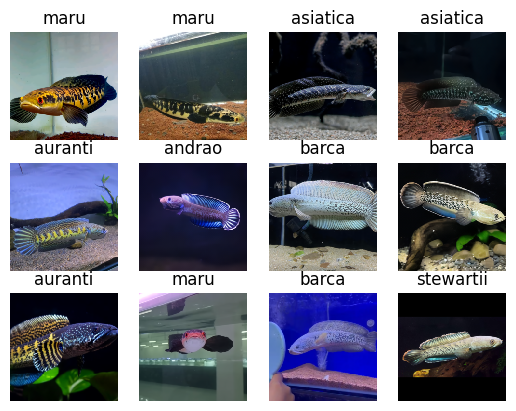

In [10]:
#cek gambar data
images, labels = next(iter(train_loader))

fig = plt.figure()
#plot gambar
for i in range(12):
    img = np.transpose(images[i-1], (1, 2, 0))
    # denormalized_img = (img * 0.5) + 0.5
    plt.subplot(3,4,i+1)
    plt.imshow(img, interpolation='none')
    plt.title(class_names[labels[i-1]])
    plt.axis('off')

plt.show()

In [11]:
#pakai model Alex yg diatur jumlah layernya
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, num_blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ResNet().to(device)

In [ ]:
#atur loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Cross Validation use 50 epoch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Split data train dan val, buat loader
train_set = dataset
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Menentukan jumlah fold untuk cross-validation
n_splits = 5

# Menyimpan nilai loss dan akurasi dari setiap fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Mengubah dataset menjadi array numpy
data_array = np.array([np.array(image) for image, _ in train_set])
labels = np.array([label for _, label in train_set])

# Membagi data menjadi fold-fold yang sesuai
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=5)

# Melakukan cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(data_array, labels)):
    print(f"Fold {fold+1}/{n_splits}")
    
    # Membagi data menjadi training set dan validation set untuk fold saat ini
    train_set_fold = torch.utils.data.Subset(train_set, train_index.tolist())
    val_set_fold = torch.utils.data.Subset(train_set, val_index.tolist())
    
    # Inisialisasi ulang model untuk setiap fold
    model = ResNet().to(device)
    
    # Menginisialisasi optimizer dan loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Membuat data loader untuk setiap fold
    train_loader_fold = DataLoader(train_set_fold, batch_size=batch_size, shuffle=True)
    val_loader_fold = DataLoader(val_set_fold, batch_size=batch_size)
    
    # Melakukan training dan evaluasi untuk setiap epoch
    for epoch in range(50):
        train_loss = 0.0
        train_correct = 0
        val_loss = 0.0
        val_correct = 0
        
        # Train the model
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader_fold):
            data, target = data.to(device), target.to(device)  # pake CUDA
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == target).sum().item()
        train_loss /= len(train_set_fold)
        train_acc = 100. * train_correct / len(train_set_fold)
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            for data, target in val_loader_fold:
                data, target = data.to(device), target.to(device)  # pake CUDA
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output.data, 1)
                val_correct += (predicted == target).sum().item()
            val_loss /= len(val_set_fold)
            val_acc = 100. * val_correct / len(val_set_fold)
        
        # Menyimpan loss dan akurasi pada setiap epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Print the results for this epoch
        print("Fold {}/{} - Epoch {}: loss {:.4f}, accuracy {:.4f}, val_loss {:.4f}, val_accuracy {:.4f}".format(
            fold+1, n_splits, epoch+1, train_loss, train_acc, val_loss, val_acc))

# Menghitung rata-rata loss dan akurasi dari semua fold
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)

# Print hasil akhir dari cross-validation
print("Average Train Loss: {:.4f}".format(avg_train_loss))
print("Average Validation Loss: {:.4f}".format(avg_val_loss))
print("Average Train Accuracy: {:.4f}".format(avg_train_acc))
print("Average Validation Accuracy: {:.4f}".format(avg_val_acc))


Fold 1/5
Fold 1/5 - Epoch 1: loss 2.0520, accuracy 28.7500, val_loss 2.4597, val_accuracy 21.6667
Fold 1/5 - Epoch 2: loss 1.6606, accuracy 32.9167, val_loss 2.5926, val_accuracy 25.0000
Fold 1/5 - Epoch 3: loss 1.5501, accuracy 38.3333, val_loss 1.8835, val_accuracy 34.1667
Fold 1/5 - Epoch 4: loss 1.5243, accuracy 40.0000, val_loss 1.7050, val_accuracy 30.8333
Fold 1/5 - Epoch 5: loss 1.5149, accuracy 40.0000, val_loss 1.9428, val_accuracy 24.1667
Fold 1/5 - Epoch 6: loss 1.5038, accuracy 40.2083, val_loss 1.8530, val_accuracy 28.3333
Fold 1/5 - Epoch 7: loss 1.4430, accuracy 41.6667, val_loss 1.6406, val_accuracy 32.5000
Fold 1/5 - Epoch 8: loss 1.3849, accuracy 43.3333, val_loss 1.5422, val_accuracy 40.8333
Fold 1/5 - Epoch 9: loss 1.3720, accuracy 45.0000, val_loss 1.5291, val_accuracy 37.5000
Fold 1/5 - Epoch 10: loss 1.3370, accuracy 46.6667, val_loss 1.4740, val_accuracy 35.8333
Fold 1/5 - Epoch 11: loss 1.3258, accuracy 46.0417, val_loss 1.4409, val_accuracy 45.0000
Fold 1/5 -

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Split data train dan val, buat loader
train_set = dataset
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Menentukan jumlah fold untuk cross-validation
n_splits = 5
num_epochs = 20

# Menyimpan nilai loss dan akurasi dari setiap fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Mengubah dataset menjadi array numpy
data_array = np.array([np.array(image) for image, _ in train_set])
labels = np.array([label for _, label in train_set])

# Membagi data menjadi fold-fold yang sesuai
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=5)

# Melakukan cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(data_array, labels)):
    print(f"Fold {fold+1}/{n_splits}")
    
    # Membagi data menjadi training set dan validation set untuk fold saat ini
    train_set_fold = torch.utils.data.Subset(train_set, train_index.tolist())
    val_set_fold = torch.utils.data.Subset(train_set, val_index.tolist())
    
    # Inisialisasi ulang model untuk setiap fold
    model = ResNet().to(device)
    
    # Menginisialisasi optimizer dan loss function
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    
    # Membuat data loader untuk setiap fold
    train_loader_fold = DataLoader(train_set_fold, batch_size=batch_size, shuffle=True)
    val_loader_fold = DataLoader(val_set_fold, batch_size=batch_size)
    
    # Training model pada setiap fold
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Set model ke mode pelatihan
        model.train()
        
        for images, labels in train_loader_fold:
            images = images.to(device)
            labels = labels.to(device)
            
            # Reset gradien parameter
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass dan optimasi
            loss.backward()
            optimizer.step()
            
            # Menghitung loss dan akurasi training
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Menghitung rata-rata loss dan akurasi training
        avg_train_loss = train_loss / train_total
        avg_train_accuracy = (train_correct / train_total) * 100.0
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        
        # Evaluasi model pada validation set
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # Set model ke mode evaluasi (non-pelatihan)
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader_fold:
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Menghitung loss dan akurasi validation
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Menghitung rata-rata loss dan akurasi validation
        avg_val_loss = val_loss / val_total
        avg_val_accuracy = (val_correct / val_total) * 100.0
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        
        # Menampilkan hasil pelatihan untuk setiap epoch
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%")


Fold 1/5
Epoch 1/20: Train Loss: 2.0092, Train Accuracy: 31.04%, Val Loss: 2.5406, Val Accuracy: 16.67%
Epoch 2/20: Train Loss: 1.5803, Train Accuracy: 47.08%, Val Loss: 2.9493, Val Accuracy: 21.67%
Epoch 3/20: Train Loss: 1.3600, Train Accuracy: 50.83%, Val Loss: 2.0867, Val Accuracy: 32.50%
Epoch 4/20: Train Loss: 1.2660, Train Accuracy: 56.04%, Val Loss: 1.3251, Val Accuracy: 51.67%
Epoch 5/20: Train Loss: 1.1171, Train Accuracy: 61.88%, Val Loss: 1.2190, Val Accuracy: 56.67%
Epoch 6/20: Train Loss: 1.0521, Train Accuracy: 64.17%, Val Loss: 1.4137, Val Accuracy: 56.67%
Epoch 7/20: Train Loss: 0.9690, Train Accuracy: 67.50%, Val Loss: 1.4333, Val Accuracy: 50.83%
Epoch 8/20: Train Loss: 0.8709, Train Accuracy: 73.54%, Val Loss: 1.1513, Val Accuracy: 59.17%
Epoch 9/20: Train Loss: 0.8055, Train Accuracy: 74.58%, Val Loss: 1.0650, Val Accuracy: 60.83%
Epoch 10/20: Train Loss: 0.7525, Train Accuracy: 77.08%, Val Loss: 1.3876, Val Accuracy: 51.67%
Epoch 11/20: Train Loss: 0.6729, Train A

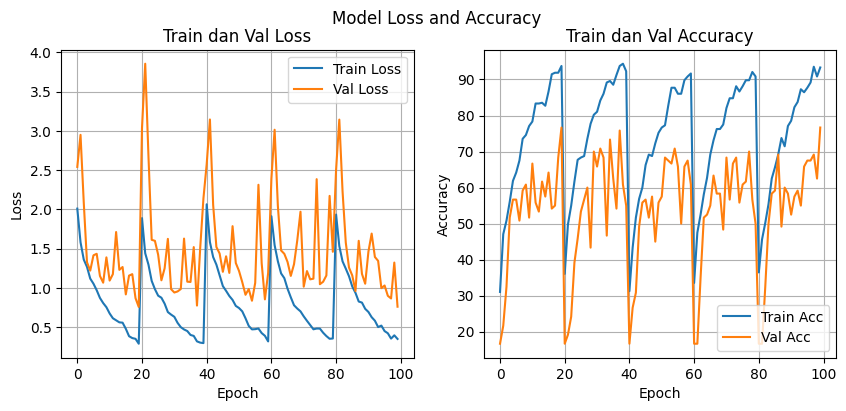

In [24]:
#bikin plot dari hasil training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train dan Val Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc')
ax2.plot(val_accuracies, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train dan Val Accuracy')
ax2.legend()
ax2.grid(True)

fig.suptitle('Model Loss and Accuracy')
plt.show()

In [26]:
#simpen model
torch.save(model.state_dict(), 'resnet_modelv5.pt')

In [28]:
#load model
model.load_state_dict(torch.load('resnet_modelv5.pt'))

<All keys matched successfully>

Saving AU5.jpg to AU5.jpg
AU5.jpg
auranti


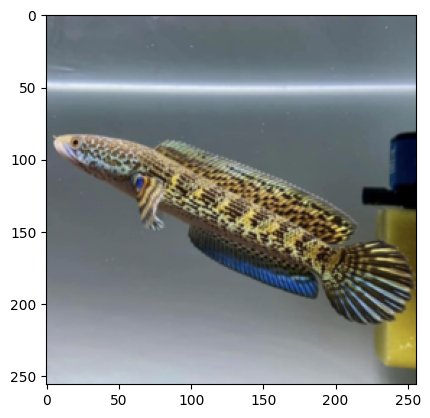

In [34]:
#pengujian model yg dilatih
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = torchvision.transforms.functional.resize(
        torchvision.transforms.functional.to_pil_image(
            np.array(Image.open(io.BytesIO(uploaded[fn])))
        ),
        (256, 256)
    )

    imgplot = plt.imshow(img)
    x = torchvision.transforms.functional.to_tensor(img)
    x = x.unsqueeze(0)
    x = x.to(device)
    
    with torch.no_grad():
        outputs = model(x)
    
    _, preds = torch.max(outputs, 1)
    
    print(fn)
    if preds.item() == 0:
        print('andrao')
    elif preds.item() == 1:
        print('asiatica')
    elif preds.item() == 2:
        print('auranti')
    elif preds.item() == 3:
        print('barca')          
    elif preds.item() == 4:
        print('maru')
    elif preds.item() == 5:
        print('stewartii')
    else:
        print('not detected')
